In [86]:
import numpy as np
import awkward as ak
import uproot_methods

In [87]:
import logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s: %(message)s')

In [88]:
def pad_array(a, maxlen, value=0., dtype='float32'):
    x = (np.ones((len(a), maxlen)) * value).astype(dtype)
    for idx, s in enumerate(a):
#         print(s)
        if not len(s):
            continue
        trunc = s[:maxlen].astype(dtype)
        x[idx, :len(trunc)] = trunc
    return x

In [89]:
##and Professor suggests that we could use mass, classifacation for later application
def SetAKArr(filepath):
    with open(filepath, 'r') as file:
        lines = file.readlines()
    prtclsdata = []
    prtclsexp = []
    _label1 = []
    _label2 = []
    _label3 = []
    _label4 = []
    _label5 = []
    
    #record the number of particles in one experiment
    for line in lines:
        if line.startswith('E'):
            if (prtclsdata):
                prtclsexp.append(prtclsdata)
                prtclsdata = []
            exp_inf = line.split()
            _label1.append(float(exp_inf[1]))
            _label2.append(float(exp_inf[2]))
            _label3.append(float(exp_inf[3]))
            _label4.append(float(exp_inf[4]))
            _label5.append(float(exp_inf[5]))
        else:
            #we ignore the photon
            par = line.split()
            prtclsdata.append(float(par[2]))
            prtclsdata.append(float(par[3]))
            prtclsdata.append(float(par[4]))
            prtclsdata.append(float(par[5]))
            prtclsdata.append(float(par[6]))
            prtclsdata.append(int(par[0]))
    if (prtclsdata):
        prtclsexp.append(prtclsdata)
    ##Create an Order Dic

    from collections import OrderedDict
    v = OrderedDict()
    prtclsexp_arr = np.array(prtclsexp)
    expinf = ak.JaggedArray.fromiter(prtclsexp_arr)
    v['allparticlesdata'] = expinf
    v['label'] = np.stack(_label5, axis = -1)
    return v

In [106]:
class Dataset(object):
    def __init__(self, filepath, feature_dict = {}, label = 'label', pad_len=24, data_format='channel_first'):
        self.filepath = filepath
        self.feature_dict = feature_dict
        if len(feature_dict) == 0:
#             feature_dict['points'] = ['part_energy', 'part_mass']
            feature_dict['features'] = ['allparticlesdata']
#             feature_dict['mask'] = ['part_energy']
        ##currently we use 'E' for experiments
        self.label = label
        self.pad_len = pad_len
        assert data_format in ('channel_first', 'channel_last')
        self.stack_axis = 1 if data_format=='channel_first' else -1
        self._values = {}
        self._label = None
        self._load()
        
    def _load(self):
        logging.info('Start loading file %s' % self.filepath)
        a = SetAKArr(self.filepath)
        self._label = a[self.label]
        for k in self.feature_dict:
                cols = self.feature_dict[k]
                if not isinstance(cols, (list, tuple)):
                    cols = [cols]
                arrs = []
                for col in cols:
                    arrs.append(pad_array(a[col], self.pad_len))
#                     print(pad_array(a[col], self.pad_len))
#                     print(type(a[col]))
                    ##check the dimesion of a[col], and it should be array.
                self._values[k] = np.stack(arrs, axis=self.stack_axis)
        logging.info('Finished loading file %s' % self.filepath)
        
    def __len__(self):
        return len(self._label)

    def __getitem__(self, key):
        if key==self.label:
            return self._label
        else:
            return self._values[key]
    
    @property
    def X(self):
        return self._values
    
    @property
    def y(self):
        return self._label

    def shuffle(self, seed=None):
        if seed is not None:
            np.random.seed(seed)
        shuffle_indices = np.arange(self.__len__())
        np.random.shuffle(shuffle_indices)
        for k in self._values:
            self._values[k] = self._values[k][shuffle_indices]
        self._label = self._label[shuffle_indices]

In [107]:
train_dataset = Dataset('train.txt', data_format='channel_last')
val_dataset = Dataset('val.txt', data_format='channel_last')
test_dataset = Dataset('test.txt', data_format = 'channel_last')

[2024-06-16 21:32:32,240] INFO: Start loading file train.txt
[2024-06-16 21:32:34,964] INFO: Finished loading file train.txt
[2024-06-16 21:32:34,965] INFO: Start loading file val.txt
[2024-06-16 21:32:35,303] INFO: Finished loading file val.txt
[2024-06-16 21:32:35,304] INFO: Start loading file test.txt
[2024-06-16 21:32:35,639] INFO: Finished loading file test.txt


In [108]:
import tensorflow as tf
from tensorflow import keras
from tf_keras_model import get_particle_net, get_particle_net_lite
from simpleModel import get_simple_model

In [109]:
# model_type = 'particle_net_lite' # choose between 'particle_net' and 'particle_net_lite'
##this shows the number of classes for classification
try:
    num_classes = train_dataset.y.shape[1]
except:
    num_classes = 1
input_shapes = {k:train_dataset[k].shape[1:] for k in train_dataset.X}
# # print(input_shapes)
# for k in train_dataset.X:
#     print(k)
#     print(train_dataset[k].shape)
# if 'lite' in model_type:
#     model = get_particle_net_lite(num_classes, input_shapes)
# else:
# model = get_particle_net(num_classes, input_shapes)
simple_model = get_simple_model(num_classes, input_shapes)

In [110]:
# Training parameters
batch_size = 384
epochs = 100

In [111]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 10:
        lr *= 0.1
    elif epoch > 20:
        lr *= 0.01
    logging.info('Learning rate: %f'%lr)
    return lr

In [112]:
simple_model.compile(loss='mean_squared_error',
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(100)),
#               optimizer=keras.optimizers.Adam(learning_rate=),
              metrics=['accuracy'])
simple_model.summary()

[2024-06-16 21:32:40,284] INFO: Learning rate: 0.000100


Model: "Simple_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
features (InputLayer)        [(None, 24, 1)]           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 24)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               3200      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 3,329
Trainable params: 3,329
Non-trainable params: 0
_________________________________________________________________


In [113]:
from tensorflow.keras.callbacks import Callback
class LossLogger(Callback):
    def __init__(self, filename):
        super().__init__()
        self.filename = filename
#         self.lb = lb

    def on_epoch_end(self, epoch, logs=None):
        with open(self.filename, 'a') as f:
#             print("Epoch ", epoch + 1,": loss = ", logs["val_loss"], "\n", file = f)
#             if (epoch+1)%5==0 or epoch==0:
            print('V ', logs['val_loss'], file = f)
            print('L', logs['loss'], file = f)
#             print()
#             f.write()
# loss_logger = LossLogger('MSE_vac_loss.txt')
loss_logger = LossLogger('MSE_loss.txt')

In [114]:
# Prepare model model saving directory.
import os
save_dir = 'model_checkpoints'
model_name = 'simple_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath='loss.txt',
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)
# I change the monitor from val_acc to val_loss
# checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
#                              monitor='val_loss',
#                              verbose=1,
#                              save_best_only=True)
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
progress_bar = keras.callbacks.ProgbarLogger()
callbacks = [checkpoint, lr_scheduler, loss_logger]
# callbacks = [lr_schedule]

In [115]:
train_dataset.shuffle()
simple_model.fit(train_dataset.X, train_dataset.y,
          batch_size=batch_size,
#           epochs=epochs,
          epochs=100,
          validation_data=(val_dataset.X, val_dataset.y),
          shuffle=True,
          callbacks=callbacks
            )

[2024-06-16 21:32:43,455] INFO: Learning rate: 0.001000


Epoch 1/100
208/208 [==============================] - ETA: 0s - accuracy: 0.0000e+00 - loss: 1.8380

[2024-06-16 21:32:43,774] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 820us/step - accuracy: 0.0000e+00 - loss: 1.8380 - val_loss: 0.0280 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:43,776] INFO: Learning rate: 0.001000


Epoch 2/100
198/208 [===========================>..] - ETA: 0s - accuracy: 0.0000e+00 - loss: 0.0181

[2024-06-16 21:32:43,898] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 582us/step - accuracy: 0.0000e+00 - loss: 0.0177 - val_loss: 0.0135 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:43,899] INFO: Learning rate: 0.001000


Epoch 3/100
190/208 [==========================>...] - ETA: 0s - accuracy: 0.0000e+00 - loss: 0.0103

[2024-06-16 21:32:44,031] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 630us/step - accuracy: 0.0000e+00 - loss: 0.0101 - val_loss: 0.0101 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:44,032] INFO: Learning rate: 0.001000


Epoch 4/100
199/208 [===========================>..] - ETA: 0s - accuracy: 0.0000e+00 - loss: 0.0078

[2024-06-16 21:32:44,152] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 576us/step - accuracy: 0.0000e+00 - loss: 0.0077 - val_loss: 0.0083 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:44,154] INFO: Learning rate: 0.001000


Epoch 5/100
185/208 [=========================>....] - ETA: 0s - accuracy: 0.0000e+00 - loss: 0.0064

[2024-06-16 21:32:44,282] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 612us/step - accuracy: 0.0000e+00 - loss: 0.0063 - val_loss: 0.0069 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:44,285] INFO: Learning rate: 0.001000


Epoch 6/100
181/208 [=========================>....] - ETA: 0s - accuracy: 0.0000e+00 - loss: 0.0051

[2024-06-16 21:32:44,416] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 629us/step - accuracy: 0.0000e+00 - loss: 0.0052 - val_loss: 0.0058 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:44,418] INFO: Learning rate: 0.001000


Epoch 7/100
191/208 [==========================>...] - ETA: 0s - accuracy: 0.0000e+00 - loss: 0.0042

[2024-06-16 21:32:44,543] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 602us/step - accuracy: 0.0000e+00 - loss: 0.0043 - val_loss: 0.0049 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:44,545] INFO: Learning rate: 0.001000


Epoch 8/100
202/208 [============================>.] - ETA: 0s - accuracy: 0.0000e+00 - loss: 0.0036

[2024-06-16 21:32:44,667] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 585us/step - accuracy: 0.0000e+00 - loss: 0.0036 - val_loss: 0.0041 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:44,669] INFO: Learning rate: 0.001000


Epoch 9/100
187/208 [=========================>....] - ETA: 0s - accuracy: 0.0000e+00 - loss: 0.0031

[2024-06-16 21:32:44,796] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 611us/step - accuracy: 0.0000e+00 - loss: 0.0031 - val_loss: 0.0035 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:44,798] INFO: Learning rate: 0.001000


Epoch 10/100
188/208 [==========================>...] - ETA: 0s - accuracy: 0.0000e+00 - loss: 0.0026

[2024-06-16 21:32:44,925] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 609us/step - accuracy: 0.0000e+00 - loss: 0.0027 - val_loss: 0.0030 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:44,927] INFO: Learning rate: 0.001000


Epoch 11/100
194/208 [==========================>...] - ETA: 0s - accuracy: 0.0000e+00 - loss: 0.0024

[2024-06-16 21:32:45,050] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 590us/step - accuracy: 0.0000e+00 - loss: 0.0023 - val_loss: 0.0026 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:45,051] INFO: Learning rate: 0.000100


Epoch 12/100
199/208 [===========================>..] - ETA: 0s - accuracy: 0.0000e+00 - loss: 0.0021

[2024-06-16 21:32:45,173] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 582us/step - accuracy: 0.0000e+00 - loss: 0.0022 - val_loss: 0.0026 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:45,175] INFO: Learning rate: 0.000100


Epoch 13/100
151/208 [====================>.........] - ETA: 0s - accuracy: 0.0000e+00 - loss: 0.0021

[2024-06-16 21:32:45,323] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 714us/step - accuracy: 0.0000e+00 - loss: 0.0021 - val_loss: 0.0025 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:45,325] INFO: Learning rate: 0.000100


Epoch 14/100
175/208 [========================>.....] - ETA: 0s - accuracy: 0.0000e+00 - loss: 0.0021

[2024-06-16 21:32:45,459] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 646us/step - accuracy: 0.0000e+00 - loss: 0.0021 - val_loss: 0.0025 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:45,461] INFO: Learning rate: 0.000100


Epoch 15/100
154/208 [=====================>........] - ETA: 0s - accuracy: 0.0000e+00 - loss: 0.0021

[2024-06-16 21:32:45,610] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 715us/step - accuracy: 0.0000e+00 - loss: 0.0021 - val_loss: 0.0024 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:45,612] INFO: Learning rate: 0.000100


Epoch 16/100
191/208 [==========================>...] - ETA: 0s - accuracy: 0.0000e+00 - loss: 0.0020

[2024-06-16 21:32:45,736] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 593us/step - accuracy: 0.0000e+00 - loss: 0.0020 - val_loss: 0.0024 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:45,738] INFO: Learning rate: 0.000100


Epoch 17/100
191/208 [==========================>...] - ETA: 0s - accuracy: 0.0000e+00 - loss: 0.0020

[2024-06-16 21:32:45,863] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 597us/step - accuracy: 0.0000e+00 - loss: 0.0020 - val_loss: 0.0024 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:45,865] INFO: Learning rate: 0.000100


Epoch 18/100
185/208 [=========================>....] - ETA: 0s - accuracy: 0.0000e+00 - loss: 0.0020

[2024-06-16 21:32:45,994] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 618us/step - accuracy: 0.0000e+00 - loss: 0.0019 - val_loss: 0.0023 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:45,996] INFO: Learning rate: 0.000100


Epoch 19/100
186/208 [=========================>....] - ETA: 0s - accuracy: 0.0000e+00 - loss: 0.0019

[2024-06-16 21:32:46,126] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 623us/step - accuracy: 0.0000e+00 - loss: 0.0019 - val_loss: 0.0023 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:46,129] INFO: Learning rate: 0.000100


Epoch 20/100
195/208 [===========================>..] - ETA: 0s - accuracy: 0.0000e+00 - loss: 0.0019

[2024-06-16 21:32:46,255] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 602us/step - accuracy: 0.0000e+00 - loss: 0.0019 - val_loss: 0.0022 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:46,257] INFO: Learning rate: 0.000100


Epoch 21/100
187/208 [=========================>....] - ETA: 0s - accuracy: 0.0000e+00 - loss: 0.0018

[2024-06-16 21:32:46,387] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 627us/step - accuracy: 0.0000e+00 - loss: 0.0018 - val_loss: 0.0022 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:46,389] INFO: Learning rate: 0.000100


Epoch 22/100
178/208 [========================>.....] - ETA: 0s - accuracy: 0.0000e+00 - loss: 0.0018

[2024-06-16 21:32:46,522] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 636us/step - accuracy: 0.0000e+00 - loss: 0.0018 - val_loss: 0.0021 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:46,524] INFO: Learning rate: 0.000100


Epoch 23/100
183/208 [=========================>....] - ETA: 0s - accuracy: 0.0000e+00 - loss: 0.0017

[2024-06-16 21:32:46,654] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 627us/step - accuracy: 0.0000e+00 - loss: 0.0018 - val_loss: 0.0020 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:46,656] INFO: Learning rate: 0.000100


Epoch 24/100
180/208 [========================>.....] - ETA: 0s - accuracy: 0.0000e+00 - loss: 0.0017

[2024-06-16 21:32:46,791] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 641us/step - accuracy: 0.0000e+00 - loss: 0.0017 - val_loss: 0.0020 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:46,793] INFO: Learning rate: 0.000100


Epoch 25/100
192/208 [==========================>...] - ETA: 0s - accuracy: 0.0000e+00 - loss: 0.0017

[2024-06-16 21:32:46,919] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 607us/step - accuracy: 0.0000e+00 - loss: 0.0017 - val_loss: 0.0019 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:46,921] INFO: Learning rate: 0.000100


Epoch 26/100
176/208 [========================>.....] - ETA: 0s - accuracy: 0.0000e+00 - loss: 0.0017  

[2024-06-16 21:32:47,054] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 638us/step - accuracy: 0.0000e+00 - loss: 0.0016 - val_loss: 0.0019 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:47,056] INFO: Learning rate: 0.000100


Epoch 27/100
192/208 [==========================>...] - ETA: 0s - accuracy: 0.0000e+00 - loss: 0.0016

[2024-06-16 21:32:47,181] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 602us/step - accuracy: 0.0000e+00 - loss: 0.0016 - val_loss: 0.0018 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:47,183] INFO: Learning rate: 0.000100


Epoch 28/100
178/208 [========================>.....] - ETA: 0s - accuracy: 0.0000e+00 - loss: 0.0015

[2024-06-16 21:32:47,319] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 650us/step - accuracy: 0.0000e+00 - loss: 0.0015 - val_loss: 0.0018 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:47,321] INFO: Learning rate: 0.000100


Epoch 29/100
182/208 [=========================>....] - ETA: 0s - accuracy: 0.0000e+00 - loss: 0.0015  

[2024-06-16 21:32:47,451] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 623us/step - accuracy: 0.0000e+00 - loss: 0.0015 - val_loss: 0.0017 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:47,453] INFO: Learning rate: 0.000100


Epoch 30/100
193/208 [==========================>...] - ETA: 0s - accuracy: 0.0000e+00 - loss: 0.0014

[2024-06-16 21:32:47,578] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 602us/step - accuracy: 0.0000e+00 - loss: 0.0015 - val_loss: 0.0017 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:47,580] INFO: Learning rate: 0.000100


Epoch 31/100
192/208 [==========================>...] - ETA: 0s - accuracy: 0.0000e+00 - loss: 0.0013

[2024-06-16 21:32:47,708] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 611us/step - accuracy: 0.0000e+00 - loss: 0.0014 - val_loss: 0.0016 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:47,709] INFO: Learning rate: 0.000100


Epoch 32/100
196/208 [===========================>..] - ETA: 0s - accuracy: 0.0000e+00 - loss: 0.0014  

[2024-06-16 21:32:47,832] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 588us/step - accuracy: 0.0000e+00 - loss: 0.0014 - val_loss: 0.0016 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:47,834] INFO: Learning rate: 0.000100


Epoch 33/100
182/208 [=========================>....] - ETA: 0s - accuracy: 0.0000e+00 - loss: 0.0014

[2024-06-16 21:32:47,964] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 626us/step - accuracy: 0.0000e+00 - loss: 0.0013 - val_loss: 0.0015 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:47,966] INFO: Learning rate: 0.000100


Epoch 34/100
179/208 [========================>.....] - ETA: 0s - accuracy: 0.0000e+00 - loss: 0.0013  

[2024-06-16 21:32:48,095] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 621us/step - accuracy: 0.0000e+00 - loss: 0.0013 - val_loss: 0.0014 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:48,097] INFO: Learning rate: 0.000100


Epoch 35/100
193/208 [==========================>...] - ETA: 0s - accuracy: 0.0000e+00 - loss: 0.0013

[2024-06-16 21:32:48,222] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 597us/step - accuracy: 0.0000e+00 - loss: 0.0012 - val_loss: 0.0014 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:48,224] INFO: Learning rate: 0.000100


Epoch 36/100
189/208 [==========================>...] - ETA: 0s - accuracy: 0.0000e+00 - loss: 0.0012

[2024-06-16 21:32:48,352] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 614us/step - accuracy: 0.0000e+00 - loss: 0.0012 - val_loss: 0.0013 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:48,353] INFO: Learning rate: 0.000100


Epoch 37/100
192/208 [==========================>...] - ETA: 0s - accuracy: 0.0000e+00 - loss: 0.0012  

[2024-06-16 21:32:48,480] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 609us/step - accuracy: 0.0000e+00 - loss: 0.0012 - val_loss: 0.0013 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:48,482] INFO: Learning rate: 0.000100


Epoch 38/100
176/208 [========================>.....] - ETA: 0s - accuracy: 0.0000e+00 - loss: 0.0011  

[2024-06-16 21:32:48,615] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 636us/step - accuracy: 0.0000e+00 - loss: 0.0011 - val_loss: 0.0012 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:48,617] INFO: Learning rate: 0.000100


Epoch 39/100
195/208 [===========================>..] - ETA: 0s - accuracy: 0.0000e+00 - loss: 0.0011

[2024-06-16 21:32:48,741] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 590us/step - accuracy: 0.0000e+00 - loss: 0.0011 - val_loss: 0.0012 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:48,742] INFO: Learning rate: 0.000100


Epoch 40/100
187/208 [=========================>....] - ETA: 0s - accuracy: 0.0000e+00 - loss: 0.0010    

[2024-06-16 21:32:48,874] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 631us/step - accuracy: 0.0000e+00 - loss: 0.0010 - val_loss: 0.0011 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:48,876] INFO: Learning rate: 0.000100


Epoch 41/100
157/208 [=====================>........] - ETA: 0s - accuracy: 0.0000e+00 - loss: 9.8710e-04

[2024-06-16 21:32:49,020] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 689us/step - accuracy: 0.0000e+00 - loss: 0.0010 - val_loss: 0.0011 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:49,022] INFO: Learning rate: 0.000100


Epoch 42/100
196/208 [===========================>..] - ETA: 0s - accuracy: 0.0000e+00 - loss: 9.8002e-04

[2024-06-16 21:32:49,145] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 592us/step - accuracy: 0.0000e+00 - loss: 9.7099e-04 - val_loss: 0.0010 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:49,147] INFO: Learning rate: 0.000100


Epoch 43/100
186/208 [=========================>....] - ETA: 0s - accuracy: 0.0000e+00 - loss: 9.4274e-04

[2024-06-16 21:32:49,275] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 612us/step - accuracy: 0.0000e+00 - loss: 9.3513e-04 - val_loss: 0.0010 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:49,277] INFO: Learning rate: 0.000100


Epoch 44/100
183/208 [=========================>....] - ETA: 0s - accuracy: 0.0000e+00 - loss: 8.8531e-04

[2024-06-16 21:32:49,472] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 934us/step - accuracy: 0.0000e+00 - loss: 8.9983e-04 - val_loss: 9.6259e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:49,474] INFO: Learning rate: 0.000100


Epoch 45/100
124/208 [================>.............] - ETA: 0s - accuracy: 0.0000e+00 - loss: 8.8794e-04

[2024-06-16 21:32:49,637] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 785us/step - accuracy: 0.0000e+00 - loss: 8.6507e-04 - val_loss: 9.2184e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:49,639] INFO: Learning rate: 0.000100


Epoch 46/100
176/208 [========================>.....] - ETA: 0s - accuracy: 0.0000e+00 - loss: 8.4365e-04

[2024-06-16 21:32:49,774] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 647us/step - accuracy: 0.0000e+00 - loss: 8.3388e-04 - val_loss: 8.8169e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:49,776] INFO: Learning rate: 0.000100


Epoch 47/100
183/208 [=========================>....] - ETA: 0s - accuracy: 0.0000e+00 - loss: 8.1196e-04

[2024-06-16 21:32:49,911] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 648us/step - accuracy: 0.0000e+00 - loss: 8.0182e-04 - val_loss: 8.4014e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:49,913] INFO: Learning rate: 0.000100


Epoch 48/100
189/208 [==========================>...] - ETA: 0s - accuracy: 0.0000e+00 - loss: 7.5228e-04

[2024-06-16 21:32:50,043] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 621us/step - accuracy: 0.0000e+00 - loss: 7.6975e-04 - val_loss: 8.1225e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:50,045] INFO: Learning rate: 0.000100


Epoch 49/100
183/208 [=========================>....] - ETA: 0s - accuracy: 0.0000e+00 - loss: 7.5209e-04

[2024-06-16 21:32:50,175] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 625us/step - accuracy: 0.0000e+00 - loss: 7.4453e-04 - val_loss: 7.6763e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:50,177] INFO: Learning rate: 0.000100


Epoch 50/100
183/208 [=========================>....] - ETA: 0s - accuracy: 0.0000e+00 - loss: 7.0824e-04

[2024-06-16 21:32:50,310] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 639us/step - accuracy: 0.0000e+00 - loss: 7.1155e-04 - val_loss: 7.4781e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:50,313] INFO: Learning rate: 0.000100


Epoch 51/100
185/208 [=========================>....] - ETA: 0s - accuracy: 0.0000e+00 - loss: 6.9947e-04

[2024-06-16 21:32:50,443] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 626us/step - accuracy: 0.0000e+00 - loss: 6.8571e-04 - val_loss: 7.0428e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:50,446] INFO: Learning rate: 0.000100


Epoch 52/100
191/208 [==========================>...] - ETA: 0s - accuracy: 0.0000e+00 - loss: 6.4651e-04

[2024-06-16 21:32:50,570] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 594us/step - accuracy: 0.0000e+00 - loss: 6.5855e-04 - val_loss: 6.8110e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:50,572] INFO: Learning rate: 0.000100


Epoch 53/100
190/208 [==========================>...] - ETA: 0s - accuracy: 0.0000e+00 - loss: 6.3150e-04

[2024-06-16 21:32:50,704] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 632us/step - accuracy: 0.0000e+00 - loss: 6.3342e-04 - val_loss: 6.5093e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:50,706] INFO: Learning rate: 0.000100


Epoch 54/100
170/208 [=======================>......] - ETA: 0s - accuracy: 0.0000e+00 - loss: 6.1508e-04

[2024-06-16 21:32:50,847] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 677us/step - accuracy: 0.0000e+00 - loss: 6.0785e-04 - val_loss: 6.2434e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:50,849] INFO: Learning rate: 0.000100


Epoch 55/100
195/208 [===========================>..] - ETA: 0s - accuracy: 0.0000e+00 - loss: 5.8602e-04

[2024-06-16 21:32:50,972] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 590us/step - accuracy: 0.0000e+00 - loss: 5.8601e-04 - val_loss: 5.9432e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:50,974] INFO: Learning rate: 0.000100


Epoch 56/100
192/208 [==========================>...] - ETA: 0s - accuracy: 0.0000e+00 - loss: 5.6740e-04

[2024-06-16 21:32:51,102] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 616us/step - accuracy: 0.0000e+00 - loss: 5.6468e-04 - val_loss: 5.6959e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:51,104] INFO: Learning rate: 0.000100


Epoch 57/100
194/208 [==========================>...] - ETA: 0s - accuracy: 0.0000e+00 - loss: 5.3326e-04

[2024-06-16 21:32:51,229] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 599us/step - accuracy: 0.0000e+00 - loss: 5.4515e-04 - val_loss: 5.6034e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:51,231] INFO: Learning rate: 0.000100


Epoch 58/100
172/208 [=======================>......] - ETA: 0s - accuracy: 0.0000e+00 - loss: 5.2940e-04

[2024-06-16 21:32:51,381] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 723us/step - accuracy: 0.0000e+00 - loss: 5.2665e-04 - val_loss: 5.3004e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:51,383] INFO: Learning rate: 0.000100


Epoch 59/100
147/208 [====================>.........] - ETA: 0s - accuracy: 0.0000e+00 - loss: 5.1656e-04

[2024-06-16 21:32:51,536] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 734us/step - accuracy: 0.0000e+00 - loss: 5.0783e-04 - val_loss: 5.0470e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:51,538] INFO: Learning rate: 0.000100


Epoch 60/100
185/208 [=========================>....] - ETA: 0s - accuracy: 0.0000e+00 - loss: 4.9994e-04

[2024-06-16 21:32:51,668] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 624us/step - accuracy: 0.0000e+00 - loss: 4.9131e-04 - val_loss: 4.8860e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:51,670] INFO: Learning rate: 0.000100


Epoch 61/100
182/208 [=========================>....] - ETA: 0s - accuracy: 0.0000e+00 - loss: 4.6895e-04

[2024-06-16 21:32:51,800] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 622us/step - accuracy: 0.0000e+00 - loss: 4.7406e-04 - val_loss: 4.7975e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:51,802] INFO: Learning rate: 0.000100


Epoch 62/100
185/208 [=========================>....] - ETA: 0s - accuracy: 0.0000e+00 - loss: 4.4403e-04

[2024-06-16 21:32:51,930] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 615us/step - accuracy: 0.0000e+00 - loss: 4.5890e-04 - val_loss: 4.5671e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:51,932] INFO: Learning rate: 0.000100


Epoch 63/100
199/208 [===========================>..] - ETA: 0s - accuracy: 0.0000e+00 - loss: 4.4624e-04

[2024-06-16 21:32:52,052] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 576us/step - accuracy: 0.0000e+00 - loss: 4.4845e-04 - val_loss: 4.6027e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:52,053] INFO: Learning rate: 0.000100


Epoch 64/100
186/208 [=========================>....] - ETA: 0s - accuracy: 0.0000e+00 - loss: 4.3647e-04

[2024-06-16 21:32:52,181] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 614us/step - accuracy: 0.0000e+00 - loss: 4.3071e-04 - val_loss: 4.2558e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:52,184] INFO: Learning rate: 0.000100


Epoch 65/100
194/208 [==========================>...] - ETA: 0s - accuracy: 0.0000e+00 - loss: 4.2127e-04

[2024-06-16 21:32:52,307] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 592us/step - accuracy: 0.0000e+00 - loss: 4.1743e-04 - val_loss: 4.1323e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:52,309] INFO: Learning rate: 0.000100


Epoch 66/100
190/208 [==========================>...] - ETA: 0s - accuracy: 0.0000e+00 - loss: 4.0964e-04

[2024-06-16 21:32:52,436] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 606us/step - accuracy: 0.0000e+00 - loss: 4.0517e-04 - val_loss: 3.9951e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:52,437] INFO: Learning rate: 0.000100


Epoch 67/100
176/208 [========================>.....] - ETA: 0s - accuracy: 0.0000e+00 - loss: 3.8626e-04

[2024-06-16 21:32:52,579] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 680us/step - accuracy: 0.0000e+00 - loss: 3.9535e-04 - val_loss: 3.8748e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:52,581] INFO: Learning rate: 0.000100


Epoch 68/100
193/208 [==========================>...] - ETA: 0s - accuracy: 0.0000e+00 - loss: 3.8201e-04

[2024-06-16 21:32:52,708] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 609us/step - accuracy: 0.0000e+00 - loss: 3.8314e-04 - val_loss: 3.7853e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:52,710] INFO: Learning rate: 0.000100


Epoch 69/100
198/208 [===========================>..] - ETA: 0s - accuracy: 0.0000e+00 - loss: 3.7536e-04

[2024-06-16 21:32:52,832] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 586us/step - accuracy: 0.0000e+00 - loss: 3.7475e-04 - val_loss: 3.7677e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:52,834] INFO: Learning rate: 0.000100


Epoch 70/100
192/208 [==========================>...] - ETA: 0s - accuracy: 0.0000e+00 - loss: 3.6674e-04

[2024-06-16 21:32:52,960] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 606us/step - accuracy: 0.0000e+00 - loss: 3.6480e-04 - val_loss: 3.5549e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:52,962] INFO: Learning rate: 0.000100


Epoch 71/100
189/208 [==========================>...] - ETA: 0s - accuracy: 0.0000e+00 - loss: 3.5899e-04

[2024-06-16 21:32:53,089] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 606us/step - accuracy: 0.0000e+00 - loss: 3.5341e-04 - val_loss: 3.4229e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:53,090] INFO: Learning rate: 0.000100


Epoch 72/100
193/208 [==========================>...] - ETA: 0s - accuracy: 0.0000e+00 - loss: 3.4751e-04

[2024-06-16 21:32:53,215] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 598us/step - accuracy: 0.0000e+00 - loss: 3.4637e-04 - val_loss: 3.3338e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:53,217] INFO: Learning rate: 0.000100


Epoch 73/100
172/208 [=======================>......] - ETA: 0s - accuracy: 0.0000e+00 - loss: 3.4400e-04

[2024-06-16 21:32:53,380] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 785us/step - accuracy: 0.0000e+00 - loss: 3.3737e-04 - val_loss: 3.2571e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:53,383] INFO: Learning rate: 0.000100


Epoch 74/100
191/208 [==========================>...] - ETA: 0s - accuracy: 0.0000e+00 - loss: 3.2473e-04

[2024-06-16 21:32:53,578] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 934us/step - accuracy: 0.0000e+00 - loss: 3.2852e-04 - val_loss: 3.2734e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:53,580] INFO: Learning rate: 0.000100


Epoch 75/100
197/208 [===========================>..] - ETA: 0s - accuracy: 0.0000e+00 - loss: 3.2169e-04

[2024-06-16 21:32:53,704] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 594us/step - accuracy: 0.0000e+00 - loss: 3.2085e-04 - val_loss: 3.1051e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:53,707] INFO: Learning rate: 0.000100


Epoch 76/100
192/208 [==========================>...] - ETA: 0s - accuracy: 0.0000e+00 - loss: 3.1807e-04

[2024-06-16 21:32:53,835] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 611us/step - accuracy: 0.0000e+00 - loss: 3.1151e-04 - val_loss: 3.0997e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:53,836] INFO: Learning rate: 0.000100


Epoch 77/100
170/208 [=======================>......] - ETA: 0s - accuracy: 0.0000e+00 - loss: 3.0185e-04

[2024-06-16 21:32:53,973] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 657us/step - accuracy: 0.0000e+00 - loss: 3.0457e-04 - val_loss: 2.9886e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:53,975] INFO: Learning rate: 0.000100


Epoch 78/100
179/208 [========================>.....] - ETA: 0s - accuracy: 0.0000e+00 - loss: 2.9405e-04

[2024-06-16 21:32:54,105] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 622us/step - accuracy: 0.0000e+00 - loss: 2.9692e-04 - val_loss: 2.8924e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:54,107] INFO: Learning rate: 0.000100


Epoch 79/100
193/208 [==========================>...] - ETA: 0s - accuracy: 0.0000e+00 - loss: 2.9385e-04

[2024-06-16 21:32:54,232] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 604us/step - accuracy: 0.0000e+00 - loss: 2.9077e-04 - val_loss: 2.8887e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:54,235] INFO: Learning rate: 0.000100


Epoch 80/100
194/208 [==========================>...] - ETA: 0s - accuracy: 0.0000e+00 - loss: 2.8285e-04

[2024-06-16 21:32:54,364] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 617us/step - accuracy: 0.0000e+00 - loss: 2.8328e-04 - val_loss: 2.7345e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:54,366] INFO: Learning rate: 0.000100


Epoch 81/100
196/208 [===========================>..] - ETA: 0s - accuracy: 0.0000e+00 - loss: 2.7569e-04

[2024-06-16 21:32:54,489] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 588us/step - accuracy: 0.0000e+00 - loss: 2.7675e-04 - val_loss: 2.6897e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:54,491] INFO: Learning rate: 0.000100


Epoch 82/100
174/208 [========================>.....] - ETA: 0s - accuracy: 0.0000e+00 - loss: 2.6946e-04

[2024-06-16 21:32:54,624] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 639us/step - accuracy: 0.0000e+00 - loss: 2.7007e-04 - val_loss: 2.6574e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:54,625] INFO: Learning rate: 0.000100


Epoch 83/100
188/208 [==========================>...] - ETA: 0s - accuracy: 0.0000e+00 - loss: 2.6361e-04

[2024-06-16 21:32:54,752] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 609us/step - accuracy: 0.0000e+00 - loss: 2.6481e-04 - val_loss: 2.6716e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:54,754] INFO: Learning rate: 0.000100


Epoch 84/100
189/208 [==========================>...] - ETA: 0s - accuracy: 0.0000e+00 - loss: 2.6036e-04

[2024-06-16 21:32:54,881] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 610us/step - accuracy: 0.0000e+00 - loss: 2.5881e-04 - val_loss: 2.4995e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:54,883] INFO: Learning rate: 0.000100


Epoch 85/100
203/208 [============================>.] - ETA: 0s - accuracy: 0.0000e+00 - loss: 2.4892e-04

[2024-06-16 21:32:55,002] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 570us/step - accuracy: 0.0000e+00 - loss: 2.5151e-04 - val_loss: 2.4747e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:55,004] INFO: Learning rate: 0.000100


Epoch 86/100
182/208 [=========================>....] - ETA: 0s - accuracy: 0.0000e+00 - loss: 2.4300e-04

[2024-06-16 21:32:55,134] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 622us/step - accuracy: 0.0000e+00 - loss: 2.4483e-04 - val_loss: 2.3826e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:55,135] INFO: Learning rate: 0.000100


Epoch 87/100
197/208 [===========================>..] - ETA: 0s - accuracy: 0.0000e+00 - loss: 2.3863e-04

[2024-06-16 21:32:55,259] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 591us/step - accuracy: 0.0000e+00 - loss: 2.3890e-04 - val_loss: 2.3434e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:55,260] INFO: Learning rate: 0.000100


Epoch 88/100
188/208 [==========================>...] - ETA: 0s - accuracy: 0.0000e+00 - loss: 2.3575e-04

[2024-06-16 21:32:55,387] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 608us/step - accuracy: 0.0000e+00 - loss: 2.3366e-04 - val_loss: 2.3722e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:55,389] INFO: Learning rate: 0.000100


Epoch 89/100
196/208 [===========================>..] - ETA: 0s - accuracy: 0.0000e+00 - loss: 2.3116e-04

[2024-06-16 21:32:55,513] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 596us/step - accuracy: 0.0000e+00 - loss: 2.3015e-04 - val_loss: 2.2537e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:55,515] INFO: Learning rate: 0.000100


Epoch 90/100
195/208 [===========================>..] - ETA: 0s - accuracy: 0.0000e+00 - loss: 2.2278e-04

[2024-06-16 21:32:55,639] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 592us/step - accuracy: 0.0000e+00 - loss: 2.2337e-04 - val_loss: 2.3509e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:55,641] INFO: Learning rate: 0.000100


Epoch 91/100
137/208 [==================>...........] - ETA: 0s - accuracy: 0.0000e+00 - loss: 2.2094e-04

[2024-06-16 21:32:55,801] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 770us/step - accuracy: 0.0000e+00 - loss: 2.1916e-04 - val_loss: 2.2509e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:55,803] INFO: Learning rate: 0.000100


Epoch 92/100
208/208 [==============================] - ETA: 0s - accuracy: 0.0000e+00 - loss: 2.1428e-04

[2024-06-16 21:32:55,972] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 813us/step - accuracy: 0.0000e+00 - loss: 2.1428e-04 - val_loss: 2.0968e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:55,974] INFO: Learning rate: 0.000100


Epoch 93/100
165/208 [======================>.......] - ETA: 0s - accuracy: 0.0000e+00 - loss: 2.0456e-04

[2024-06-16 21:32:56,115] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 676us/step - accuracy: 0.0000e+00 - loss: 2.0784e-04 - val_loss: 2.0766e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:56,117] INFO: Learning rate: 0.000100


Epoch 94/100
173/208 [=======================>......] - ETA: 0s - accuracy: 0.0000e+00 - loss: 2.0147e-04

[2024-06-16 21:32:56,255] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 661us/step - accuracy: 0.0000e+00 - loss: 2.0437e-04 - val_loss: 2.0613e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:56,257] INFO: Learning rate: 0.000100


Epoch 95/100
192/208 [==========================>...] - ETA: 0s - accuracy: 0.0000e+00 - loss: 2.0396e-04

[2024-06-16 21:32:56,381] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 593us/step - accuracy: 0.0000e+00 - loss: 2.0021e-04 - val_loss: 1.9638e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:56,383] INFO: Learning rate: 0.000100


Epoch 96/100
189/208 [==========================>...] - ETA: 0s - accuracy: 0.0000e+00 - loss: 1.9527e-04

[2024-06-16 21:32:56,511] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 615us/step - accuracy: 0.0000e+00 - loss: 1.9475e-04 - val_loss: 1.9125e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:56,513] INFO: Learning rate: 0.000100


Epoch 97/100
179/208 [========================>.....] - ETA: 0s - accuracy: 0.0000e+00 - loss: 1.9240e-04

[2024-06-16 21:32:56,651] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 662us/step - accuracy: 0.0000e+00 - loss: 1.9181e-04 - val_loss: 2.0355e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:56,653] INFO: Learning rate: 0.000100


Epoch 98/100
146/208 [====================>.........] - ETA: 0s - accuracy: 0.0000e+00 - loss: 1.8957e-04

[2024-06-16 21:32:56,805] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 733us/step - accuracy: 0.0000e+00 - loss: 1.8707e-04 - val_loss: 1.8215e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:56,807] INFO: Learning rate: 0.000100


Epoch 99/100
190/208 [==========================>...] - ETA: 0s - accuracy: 0.0000e+00 - loss: 1.8347e-04

[2024-06-16 21:32:56,936] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 618us/step - accuracy: 0.0000e+00 - loss: 1.8205e-04 - val_loss: 1.8009e-04 - val_accuracy: 0.0000e+00


[2024-06-16 21:32:56,938] INFO: Learning rate: 0.000100


Epoch 100/100
198/208 [===========================>..] - ETA: 0s - accuracy: 0.0000e+00 - loss: 1.7815e-04

[2024-06-16 21:32:57,062] WARNING: Can save best model only with val_acc available, skipping.


208/208 [==============================] - 0s 596us/step - accuracy: 0.0000e+00 - loss: 1.7755e-04 - val_loss: 1.8226e-04 - val_accuracy: 0.0000e+00


In [116]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%config InlineBackend.figure_format = 'retina'
def PlotPrediction(filepath, fig, tag):
    #open files
    with open(filepath, 'r') as file:
        lines = file.readlines()
    output = open('100pre_MEPoint.txt', 'w')
        
    ##this piece of code would load the 
    ##real particle infor in order to be compared with the predictions
    true_vals = []
    true_val = []
    masses = []
    for line in lines:
        if line.startswith('E'):
            if not true_val:
                true_vals.append(true_val)
            true_val = []
            info = line.split()
            px = float(info[1])
            py = float(info[2])
            pz = float(info[3])
            engy = float(info[4])
            mass = float(info[5])
            true_val.append(px)
            true_val.append(py)
            true_val.append(pz)
            true_val.append(engy)
            true_val.append(mass)
            if tag == 'Px':
                masses.append(px)
            elif tag == 'Py':
                masses.append(py)
            elif tag == 'Pz':
                masses.append(pz)
            elif tag == 'Engy':
                masses.append(engy)
            else:
                masses.append(mass)
    
    predictions = simple_model.predict(test_dataset.X)
    print(predictions)
    x = []
    for i in range(0, predictions.size):
        x.append(i)
        i += 1
    quans = []
##this is for multiple output variables
#     if tag == 'Px':
#         idx = 0
#     elif tag == 'Py':
#         idx = 1
#     elif tag == 'Pz':
#         idx = 2
#     elif tag == 'Engy':
#         idx = 3
#     else:
#         idx = 4
    #idx = mass
    idx = 0
    for prediction in predictions:
        #this would grab the desired information
        quan = prediction[idx]
        quans.append(quan)
        ##his would output the prediction into text
        for energy_momentum in prediction:
            print(energy_momentum, end='', file=output)
        print('', file=output)
        
#     fig, ax = plt.subplots()
#     ax.set_title("Mass Prediction")
#     plt.xlabel("Number of Prediction")
#     plt.ylabel("Mass")
#     ax.scatter(x, masses, linewidth=2.0, color = 'blue')

    plt.hist(quans, 40, label='prediction', density=False, color = 'g', alpha = 0.75)
    plt.hist(masses, 40, label='prediction', density=False, histtype = 'step', cumulative=False, color = 'b', alpha = 0.75)
    plt.xlabel(tag+'(GeV)')
    plt.ylabel('Predictions')
    plt.title(tag+'Prediction of MSE')
    plt.grid(True)

#     plt.legend(
#     loc='best',
#     labels = ['log_cosh', 'mse'])
#     plt.show()
    plt.savefig(fig)

[[5.2821536]
 [5.279735 ]
 [5.274855 ]
 ...
 [5.2603035]
 [5.28342  ]
 [5.293037 ]]


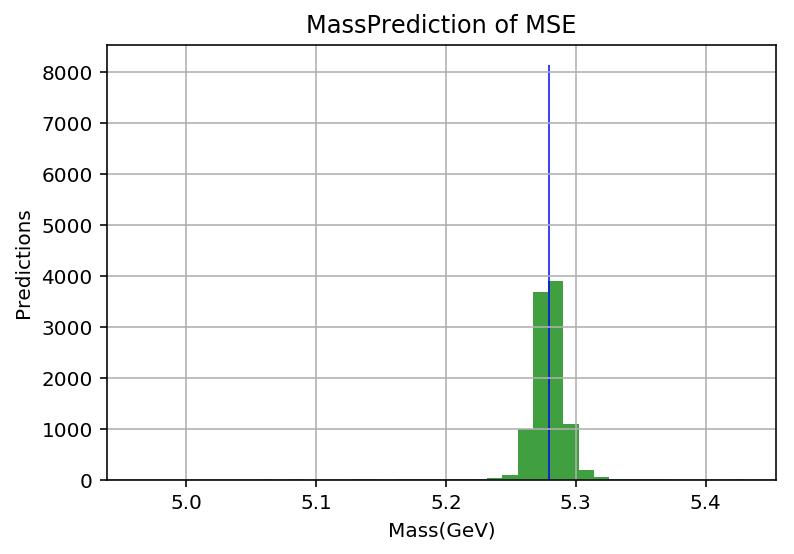

In [117]:
PlotPrediction('test.txt','predictions/Mass_100epPre.png','Mass')

In [118]:
def PlotWithoutModel(filepath, fig, tag):
    TrueMass = 5.27933
    with open(filepath, 'r') as file:
        lines = file.readlines()
    masses = []
    for line in lines:
        masses.append(float(line))
    plt.hist(masses, 40, label='prediction', density=False, color = 'g', alpha = 0.75)
    # Mark True mass
    plt.axvline(TrueMass, color='red', linestyle='--', label='Marked Point')
    
    plt.xlabel(tag+'(GeV)')
    plt.ylabel('Predictions')
    plt.title(tag+'Prediction of MSE')
    plt.grid(True)
    plt.savefig(fig)

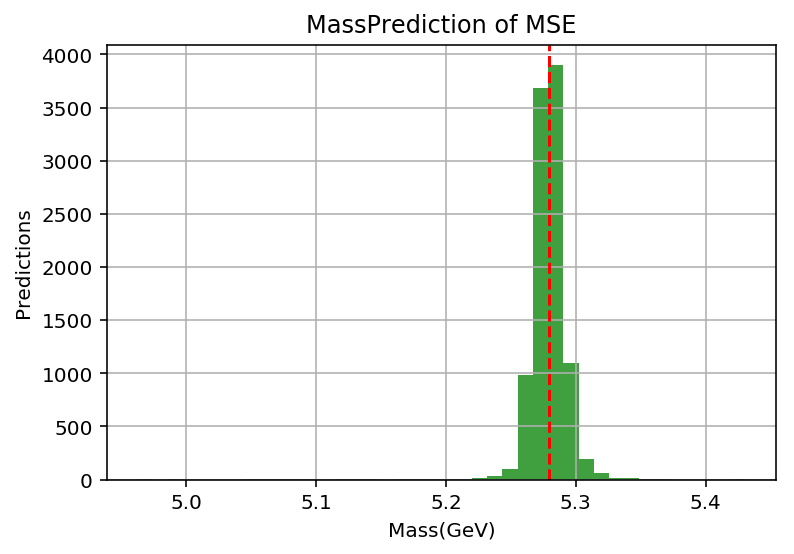

In [119]:
PlotWithoutModel('100pre_MEPoint.txt', '100masspre.png', 'Mass')